# ARIMA Modeling of Seasonal Flu 
**Steven Hayden, Kevin Mendosna, Joseph Schueder, and Nicole Wittlin**

## Introduction/Overview

The Covid-19 Pandemic has taken an unprecedented toll on our country's health systems, and as the US prepares for an upcoming influenza season this fall, it is critical to equip our providers with all the equipment necessary. To that end, officials at the Strategic National Stockpile have asked our team to assist them in projecting the flu season in the upcoming few years. This will help the agency determine how to replenish the stockpile with flu season in mind.

We have partnered with the Center for Disease Control (CDC) Influenza Division for data, as the CDC collects, complies, and analyzes information on influenza virus activity year-round in the United States. Annual influenza surveillance entails voluntary reporting by public health partners and health-care providers about which virus strains are circulating when and where. Data is reported weekly, Sunday through Saturday, and "flu season" usually begins around October and peaks from December to February, sometimes remaining elevated until May. As a result, the start date each year is around week 40 and ends 39 of the subsequent year. For example, the 2019-2020 flu season began September 29, 2019 and will end September 26, 2020. 

Given the seasonal nature of the influenza virus, the most appropriate analysis methods are for time series, which seek to extract meaningful statistics and other data characteristics in relation to defined time periods. These methods are used to analyze "non-stationary data" such as weather data, economic data, retail data, and other time-defined datasets. Since time series data are time dependent, observations are not independent, likely have some increasing or decreasing overall trend, and have a seasonality trend. The specific aspects direct how the analysis should be conducted.   

## Data Preparation (Q1)

Our team retrieved the data from the CDC's FluView Interactive online application that houses weekly flu surveillance data. Typically, the data is received from several sources, including public health labs, clinical labs, and outpatient healthcare providers. All reports include the number of specimens tested and the number of positive cases, plus age/age group if available. The approximately 100 reporting public health labs also test for virus types and subtypes and report on the lineages circulating among which age groups. Clinical labs primarily test for diagnostic purposes to determine timing and intensity of flu activity. The 300 labs commonly report number of specimens tested, number positive, and number positive of each type. Combined these two sources are compose the World Health Organization Collaborating Laboratories System and National Respiratory and Enteric Viruc Surveillance Systems (WHO/NREVSS). A third source of data comes from outpatient healthcare providers in all 50 states, Puerto Rico, DC, and the US Virgin Islands that report "influenza-like illness," which are a fever plus cough and/or sore throat. This ILINet data combines state-specific data weighted by state population. 

Our team elected to use the WHO/NREVSS data from public and clinical labs, so we combined this data into one dataset with year, week, specimens tested, specimens positive, and details about specific strains. The CDC noted that for efficiency, public health labs often receive samples that have already tested positive in a clinical lab. Thus, we acknowledge there may a higher positive percentage in the data. This over-estimation would lead to more supplies needed, rather than less, so we feel this duplication will not negatively impact our analysis. Additionally, we elected to not use the "influenza-like" ILINet data since it does not directly confirm a tested specimen.


### Exploratory Data Analysis 

**SOMEWHERE EXPLAIN THAT DATA SET GOES FROM 1997 to 2020 but we are using 2015 - 2019 for initial analysis, will expand as needed.**

**Given that the start date of flu season each year is approximate, we elected to conduct our analysis with a time window from July 1 to June 30. This will still capture appropriate seasonality and may help with consistency from year to year.

In [1]:
import warnings
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

In [2]:
#National level data
dfx = pd.read_csv(r'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%204/NationalCombined_UpTo_2020.csv')    

In [3]:
dfx.head()

,Year,Week,PositiveCases
0,1997,40,0
1,1997,41,11
2,1997,42,17
3,1997,43,7
4,1997,44,10


In [4]:
dfx.tail()

,Year,Week,PositiveCases
1180,2020,20,48
1181,2020,21,17
1182,2020,22,14
1183,2020,23,21
1184,2020,24,10


In [5]:
dfx.describe()

,Year,Week,PositiveCases
count,1185.000000,1185.000000,1185.000000
mean,2008.596624,26.519831,1560.747679
std,6.570896,15.142169,3653.877099
min,1997.000000,1.000000,0.000000
25%,2003.000000,13.000000,23.000000
50%,2009.000000,26.000000,207.000000
75%,2014.000000,40.000000,1173.000000
max,2020.000000,53.000000,26386.000000


In [6]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 3 columns):
Year             1185 non-null int64
Week             1185 non-null int64
PositiveCases    1185 non-null int64
dtypes: int64(3)
memory usage: 27.9 KB


In [39]:
#!python -m pip install --upgrade pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(dfx, plot={'histogram': {'bins': 8}}, explorative=True)
profile.to_notebook_iframe()
profile.to_file("FluData_EDA_Report.html")

In [7]:
dfx['Date'] = pd.to_datetime(dfx.Year.astype(str), format='%Y') + \
             pd.to_timedelta(dfx.Week.mul(7).astype(str) + ' days')

#dfx['PERCENT POSITIVE DEC'] = dfx['PERCENT POSITIVE'] / 100
#dfx['COUNT POSITIVE'] = dfx['TOTAL SPECIMENS'] * dfx['PERCENT POSITIVE DEC']
#created this column so the rest of the code did not need to be replaced. 
dfx['COUNT POSITIVE']=dfx['PositiveCases']

Set up annual analysis from July 1 to June 30. We acknowledge that this does not directly correspond to approximate flu season dates but believe it still captures seasonality and provides more consistency.

In [8]:
# Set up July 1 to June 30 time frame
dfx = dfx.loc[dfx['Date'] >= '2015-07-01' ]
dfx = dfx.loc[dfx['Date'] < '2020-07-01']

In [9]:
dfx

,Year,Week,PositiveCases,Date,COUNT POSITIVE
926,2015,26,129,2015-07-02,129
927,2015,27,99,2015-07-09,99
928,2015,28,86,2015-07-16,86
929,2015,29,73,2015-07-23,73
930,2015,30,73,2015-07-30,73
...,...,...,...,...,...
1180,2020,20,48,2020-05-20,48
1181,2020,21,17,2020-05-27,17
1182,2020,22,14,2020-06-03,14
1183,2020,23,21,2020-06-10,21


In [10]:
dfx['Date'].min(), dfx['Date'].max()

(Timestamp('2015-07-02 00:00:00'), Timestamp('2020-06-17 00:00:00'))

In [11]:
#Check for Missing Values
dfx = dfx.sort_values('Date')
dfx.isnull().sum()

Year              0
Week              0
PositiveCases     0
Date              0
COUNT POSITIVE    0
dtype: int64

In [12]:
dfx2 = dfx.groupby('Date')['COUNT POSITIVE'].sum().reset_index()
dfx2

,Date,COUNT POSITIVE
0,2015-07-02,129
1,2015-07-09,99
2,2015-07-16,86
3,2015-07-23,73
4,2015-07-30,73
...,...,...
254,2020-05-20,48
255,2020-05-27,17
256,2020-06-03,14
257,2020-06-10,21


## Indexing with Time Series Data
With the exploratory data analysis complete, we need to index the data before proceeding with our analysis. Given the nature of this time series flu data, we need to be able to conduct weekly analysis. The indexing process will allow us to compare week to week through the season and week to week across the years in the sample. Note, unlike numeric indexing where the end index is usually not included, here the end index **is** included. Indices also have to be sorted in order and should not be randomized. 

In [13]:
#dfx2 = dfx2.set_index('Date')
dfx2.index = pd.DatetimeIndex(dfx2.Date).to_period('W')
dfx2.index
#dfx2.index = pd.DatetimeIndex(dfx2.index).to_period('W')# just added this 

PeriodIndex(['2015-06-29/2015-07-05', '2015-07-06/2015-07-12',
             '2015-07-13/2015-07-19', '2015-07-20/2015-07-26',
             '2015-07-27/2015-08-02', '2015-08-03/2015-08-09',
             '2015-08-10/2015-08-16', '2015-08-17/2015-08-23',
             '2015-08-24/2015-08-30', '2015-08-31/2015-09-06',
             ...
             '2020-04-13/2020-04-19', '2020-04-20/2020-04-26',
             '2020-04-27/2020-05-03', '2020-05-04/2020-05-10',
             '2020-05-11/2020-05-17', '2020-05-18/2020-05-24',
             '2020-05-25/2020-05-31', '2020-06-01/2020-06-07',
             '2020-06-08/2020-06-14', '2020-06-15/2020-06-21'],
            dtype='period[W-SUN]', name='Date', length=259, freq='W-SUN')

Review the Flu data from the 2015/2016 flu season through the 2018/2019 flu season

In [14]:
y=dfx2['COUNT POSITIVE']

In [15]:
y

Date
2015-06-29/2015-07-05    129
2015-07-06/2015-07-12     99
2015-07-13/2015-07-19     86
2015-07-20/2015-07-26     73
2015-07-27/2015-08-02     73
                        ... 
2020-05-18/2020-05-24     48
2020-05-25/2020-05-31     17
2020-06-01/2020-06-07     14
2020-06-08/2020-06-14     21
2020-06-15/2020-06-21     10
Freq: W-SUN, Name: COUNT POSITIVE, Length: 259, dtype: int64

In [16]:
dfx.head()

,Year,Week,PositiveCases,Date,COUNT POSITIVE
926,2015,26,129,2015-07-02,129
927,2015,27,99,2015-07-09,99
928,2015,28,86,2015-07-16,86
929,2015,29,73,2015-07-23,73
930,2015,30,73,2015-07-30,73


## Analysis

### Visualize Time Series Data
The first step in time series analysis is to visualize the data. This will initially reveal if the data has "seasonal peaks" (patterns that recur in a specific time frame) and whether the data has an overall upward or downward trend over time. Combined, these to characteristics will indicate if the data has "stationarity." Stationary data is an assumption for time series models and reflects constant statistical properties of mean and variance over time.

Our first visual analysis, the Flu Cases over Time cart below, reveals several key points about stationarity. First, **the observations look seasonal, with peaks of flu cases occurring just after each new year.** Also, the **the peaks each year appear to trend upward.** Both of these indicate that this is not stationary data.


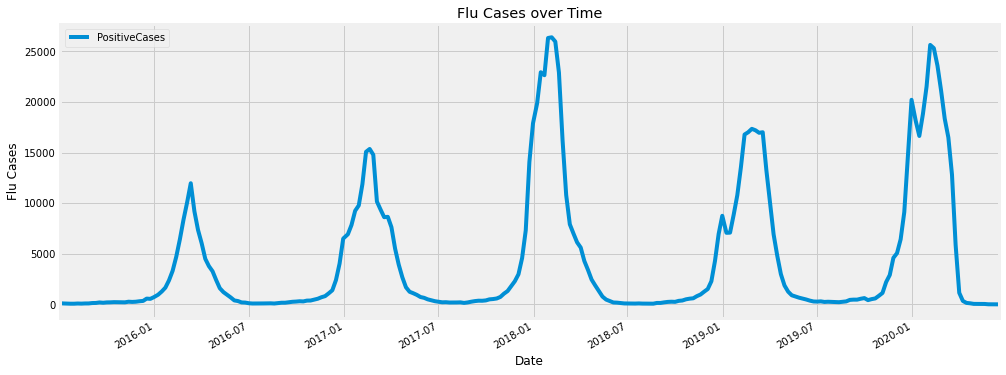

In [17]:
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
dfx3 = dfx[['Date','PositiveCases']].copy()
dfx3 = dfx3.set_index('Date')
dfx3.plot(figsize=(15, 6))
plt.ylabel('Flu Cases')
plt.title('Flu Cases over Time')
y3=dfx3['PositiveCases']
plt.show()

The next visual check to be done using a method called **"time-series decomposition"**, which allows us to separate our time series data into three distinct components: trend, seasonality, and noise. The chart below shows four panels: observed data, trend data, seasonal component, and residuals.

Visual analysis of the decomposition graphs illuminate several, additional key points about our time series data set. The top chart, of *observed data*, puts the realization chart in alignment by time with the trend, seasonal, and residuals. With the components separated, the second chart *trend* indicates an increase over time by looking at the moving average. The third chart *seasonality* removes the trend from the observations, so the peaks can be compared with each other and their intervals. We can see that the peaks are consistently happening early in the year. This supports our initial assumption that this is non-stationary data. For Stationary data, the residual plot should appear random.


In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq = 52)


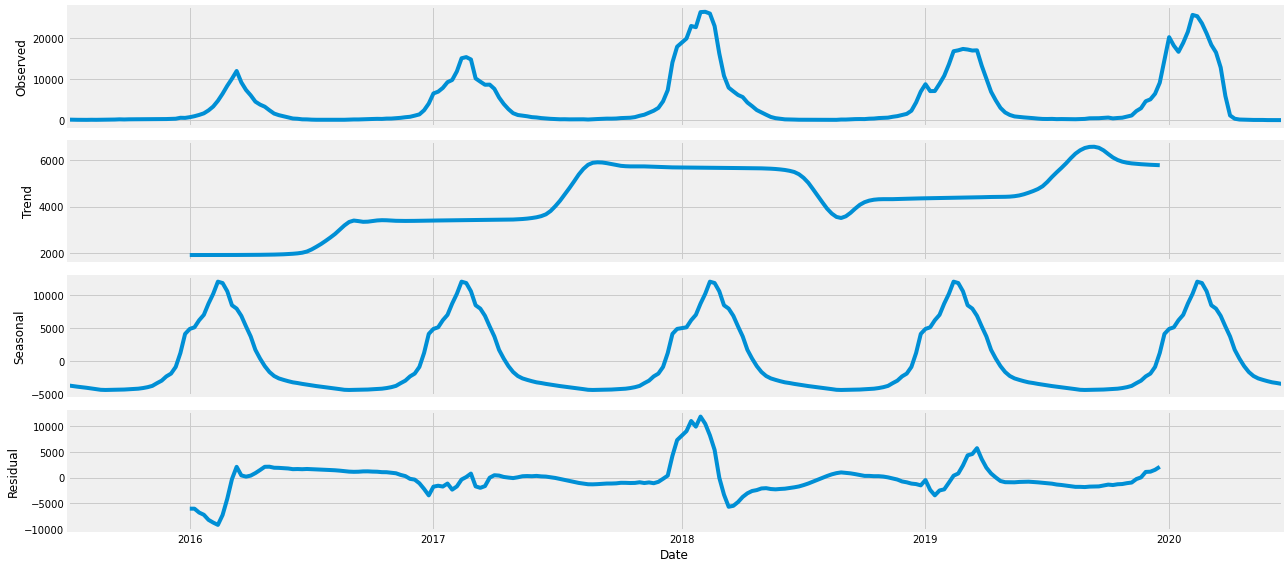

In [19]:
import warnings
warnings.filterwarnings('ignore')
fig = decomposition.plot()
plt.show()

We conduct one final plot of the Autocorrelation of the data. From the chart below, it appears our data displays serial autocorrelation as there is correlation between many lags of the data. While this would suggest the data may need to be modified before conducting an ARIMA time series analysis, we will run the Dickey-Fuller test to confirm.

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, second):
    
    #Determing rolling statistics
    rolmean = second.rolling(52).mean()
    rolstd = second.rolling(52).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20, 4))
    orig = plt.plot(second, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Text(0.5, 1.0, 'Autocorrelation Function')

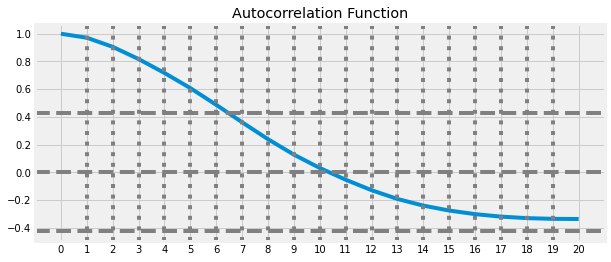

In [21]:
from statsmodels.tsa.stattools import acf, pacf
acf_dif_y = acf(y.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_dif_y)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_dif_y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_dif_y)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

The Dickey-Fuller test can statistically confirm the stationarity of our data. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
- **Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- **Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Note: the p-values are obtained through regression surface approximation from MacKinnon 1994, but we used the updated 2010 tables. If the p-value is close to the significance level, then the critical values should be used to judge whether to reject the null hypothesis.

The results of the Dickey-Fuller test on the baseline seasonal flu data reject the Null Hypothesis (p-value = 0.000018) and indicates there is not sufficient evidence to confirm the data has a time dependent structure. 

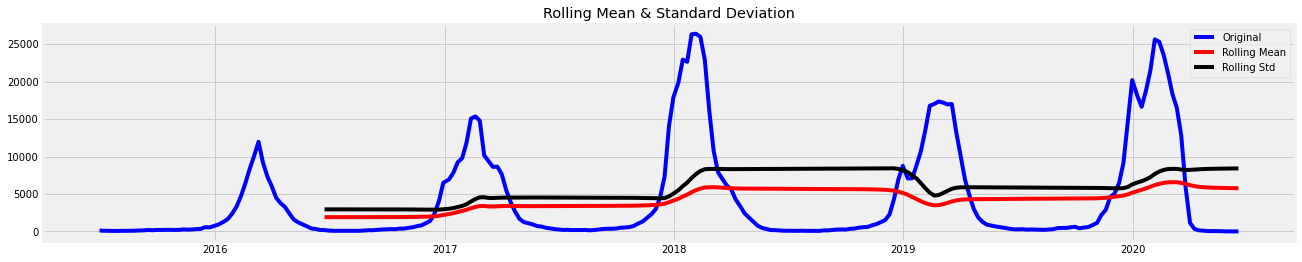

Results of Dickey-Fuller Test:
Test Statistic                  -4.782835
p-value                          0.000059
#Lags Used                       6.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [22]:
test_stationarity(y.dropna(),y3.dropna())

To improve the stationarity of the data, we can do a transformation by shifting the data by one week. This is helpful for lag correlated data. However, the Dickey-Fuller test fails to reject the null hypothesis on the shifted data. We will need to try another technique to improve stationarity. 

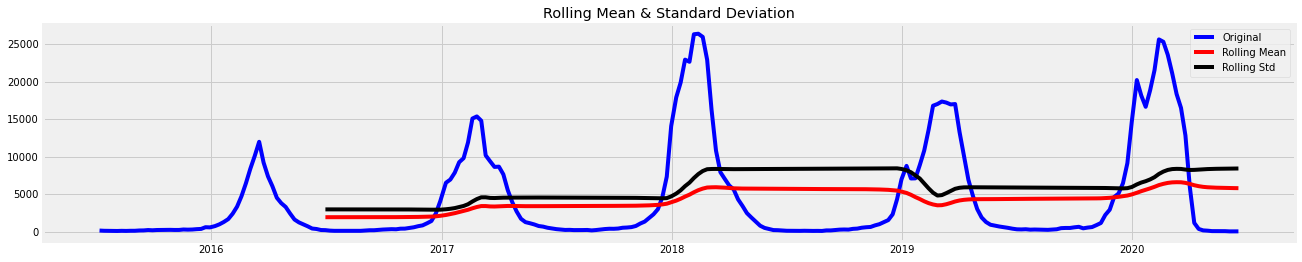

Results of Dickey-Fuller Test:
Test Statistic                  -4.781278
p-value                          0.000059
#Lags Used                       6.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [23]:
# we should diffrence the data here and fit the model on this dataset but also keep the un diffecned data 
#diff_air_pop = log_air_pop-log_air_pop.shift(1) # Changing the shift value is equivalent to changing your 'd' value
#test_stationarity(diff_air_pop.dropna())
from statsmodels.tsa.stattools import adfuller

dif_y=y.shift(1)
dif_y3 =y3.shift(1)
test_stationarity(dif_y.dropna(),dif_y3.dropna())

Now, we transform the data by differencing. The results of the Dickey-Fuller test on the differenced data again fail to reject the null hypotheses. We have not yet achieved enough stationarity in the data to proceed with our analysis. 

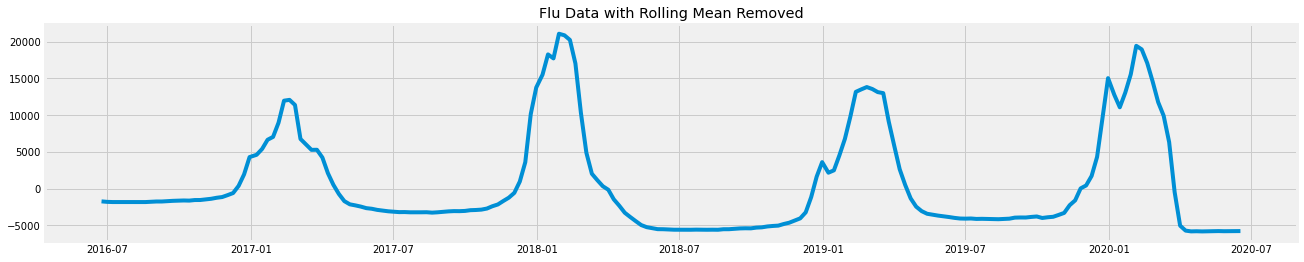

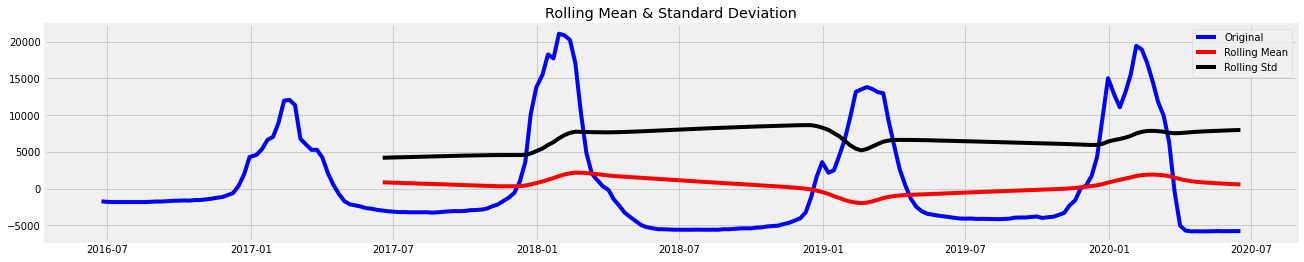

Results of Dickey-Fuller Test:
Test Statistic                  -4.421515
p-value                          0.000272
#Lags Used                       6.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [24]:
moving_avg = y.rolling(52).mean()
moving_avg3 = y3.rolling(52).mean()
no_trend = y - moving_avg
no_trend3 = y3 - moving_avg3
plt.figure(figsize=(20, 4))
plt.plot(no_trend3)
plt.title("Flu Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna(), no_trend3.dropna())

**Unfortunately, shifting the data, differencing the data, and removing the rolling mean from the data all do not bring our data set to an acceptable level of stationarity. Therefore, we will modify our methodology slightly when building the time series model.**

### Optimal Parameters: Plot ACF and PACF 

  
  With the data more stationary, we can begin to explore the optimal parameters for our time series modeling. Part of this process will be to look at the **Autocorrelation Function (ACF)** and the **Partial Autocorrelation Function (PACF)**.

    
   The **ACF** measures the correlation between the time series data and a lagged version of itself, or stated another way it measures the correlation between time series observations separated by *k* time units. The 

   The  **PACF** measures correlation between time series data and a lagged version of itself *after* eliminating variations already explained above (i.e. seasonality and trend). It measures the strength of the relationship of data with the other terms being accounted for.

   Looking at the ACF and PACF plots together can help identify the what model to fit on our time series data. In our data, **[HELP HERE: For example, a large spike appears at Lag_17 and Lag_16 for the transformed data and then again at Lag_52. This makes sense as you would expect the same time the previous year would have a similar count of cases.]** 


Lags in the confidence interval is good. 1 or 2 is okay, but no more. 

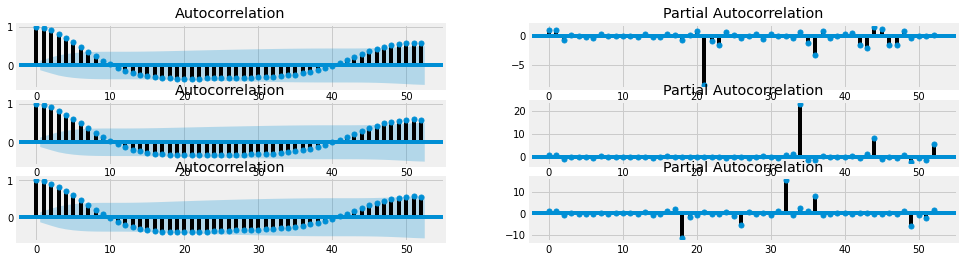

In [25]:
# Graph data
fig, axes = plt.subplots(3, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(y.dropna(), lags=52, ax=axes[0,0])
fig = sm.graphics.tsa.plot_pacf(y.dropna(), lags=52, ax=axes[0,1])
fig = sm.graphics.tsa.plot_acf(dif_y.dropna(), lags=52, ax=axes[1,0])
fig = sm.graphics.tsa.plot_pacf(dif_y.dropna(), lags=52, ax=axes[1,1])
fig = sm.graphics.tsa.plot_acf(no_trend.dropna(), lags=52, ax=axes[2,0])
fig = sm.graphics.tsa.plot_pacf(no_trend.dropna(), lags=52, ax=axes[2,1])

###### We use SARIMA function to help estimate the model instead of ARIMA because the was not sufficiently stationary after the transformation. The SARIMA has better tolerance for estimation models when non-stationary data is provided. 

### Build ARIMA Model (Q2)

###### We use SARIMA function to help estimate the model instead of ARIMA because the was not sufficiently stationary after the transformation. The SARIMA has better tolerance for estimation models when non-stationary data is provided. 

One of the most commonly used methods for time series forecasting is ARIMA, which stands for an Autoregressive Integrated Moving Average model. To fully understand ARIMA, it can be broken down into three components that align with the parameters of the model that correspond to seasonality, trend, and noise in the data. 

- **AR** stands for Autoregressive, which means that the current predictions depend on past results in the form of lags on the dependent variable; this parameter, represented by **p**, uses the dependent relationship between observations and lagged observations. **p** denotes the number of lags or the lag order of the model. One way to define p is to observe where the PACF plot crosses the upper confidence interval for the first time.
- **I** stands for integrated, which considers how to difference the raw data to improve stationarity. This parameter is represented by **d**, the number of times the data observations are differenced; also known as the degree of differencing.
- **MA** stands for Moving Average and takes into account previous results, nonseasonal differences, and the dependency between observations and residuals. Essentially, it compares a moving window of observations to lagged observations. Represented in the model by **q**, it is the order (or size) of the moving average. One way to define q is to observe where the ACF crosses the upper confidence interval for the first time. 

A major assumption of the ARIMA model is stationarity in the data, meaning that no trend or seasonality is present. In our data set, we were not able to achieve an appropriate level of stationarity. Therefore, we are going to use the **SARIMA** model. The SARIMA has better tolerance for estimation with non-stationary data.

**HOW ARE SARIMA parameters different than ARIMA parameters?**
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
ARIMA doesn't support seasonality, SARIMA helps this. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

It adds three new hyperparameters for the seasonal component of the serie to specify:
* the autoregression (AR), 
* differencing (I)
* moving average (MA) 

An additional parameter for the period(m) of the seasonality is also added. An m of 52 for weekly data suggests a yearly seasonal cycle.

Seasonal ARIMA models can potentially have a large number of parameters and combinations of terms. Therefore, it is appropriate to try out a wide range of models when fitting to data and choose a best fitting model using an appropriate criterion …

— Pages 143-144, Introductory Time Series with R, 2009.
https://www.amazon.com/Introductory-Time-R-Use/dp/0387886974/ref=as_li_ss_tl?ie=UTF8&qid=1527719321&sr=8-1&keywords=introductory+time+series+with+r&linkCode=sl1&tag=inspiredalgor-20&linkId=235af99b9443823b7dcf05007a3ed7bb

In [28]:
# need to see if we can get this to iterate 
p = range(3, 7)
d = range(0, 3)
q = range(0, 3)

#pdq = list(itertools.permutations(p, d, q),3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [29]:
#list([list(p),list(d),list(q)])
seasonal_pdq

[(3, 0, 0, 52),
 (3, 0, 1, 52),
 (3, 0, 2, 52),
 (3, 1, 0, 52),
 (3, 1, 1, 52),
 (3, 1, 2, 52),
 (3, 2, 0, 52),
 (3, 2, 1, 52),
 (3, 2, 2, 52),
 (4, 0, 0, 52),
 (4, 0, 1, 52),
 (4, 0, 2, 52),
 (4, 1, 0, 52),
 (4, 1, 1, 52),
 (4, 1, 2, 52),
 (4, 2, 0, 52),
 (4, 2, 1, 52),
 (4, 2, 2, 52),
 (5, 0, 0, 52),
 (5, 0, 1, 52),
 (5, 0, 2, 52),
 (5, 1, 0, 52),
 (5, 1, 1, 52),
 (5, 1, 2, 52),
 (5, 2, 0, 52),
 (5, 2, 1, 52),
 (5, 2, 2, 52),
 (6, 0, 0, 52),
 (6, 0, 1, 52),
 (6, 0, 2, 52),
 (6, 1, 0, 52),
 (6, 1, 1, 52),
 (6, 1, 2, 52),
 (6, 2, 0, 52),
 (6, 2, 1, 52),
 (6, 2, 2, 52)]

**DO WE NEED THIS**

This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.



#### If simple_differencing=True, then the time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series. 

In [33]:
%%time
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
df = pd.DataFrame(columns=['param', 'param_seasonal', 'resultsaic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(no_trend.dropna(),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
 #           df.append({'param': param, 'param_seasonal': param_season, 'resultsaic': results.aic}, ignore_index=True)
        except:
            continue
            
#            df = pd.DataFrame('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(3, 0, 0)x(3, 0, 0, 52)52 - AIC:14.0
ARIMA(3, 0, 0)x(3, 0, 1, 52)52 - AIC:16.0
ARIMA(3, 0, 1)x(3, 0, 0, 52)52 - AIC:16.0
ARIMA(3, 0, 1)x(3, 0, 1, 52)52 - AIC:18.0
ARIMA(3, 0, 2)x(3, 0, 0, 52)52 - AIC:18.0
ARIMA(3, 0, 2)x(3, 0, 1, 52)52 - AIC:20.0
ARIMA(4, 0, 0)x(3, 0, 0, 52)52 - AIC:16.0
ARIMA(4, 0, 0)x(3, 0, 1, 52)52 - AIC:18.0
ARIMA(4, 0, 1)x(3, 0, 0, 52)52 - AIC:18.0
ARIMA(4, 0, 1)x(3, 0, 1, 52)52 - AIC:20.0
ARIMA(4, 0, 2)x(3, 0, 0, 52)52 - AIC:20.0
ARIMA(4, 0, 2)x(3, 0, 1, 52)52 - AIC:22.0
ARIMA(5, 0, 0)x(3, 0, 0, 52)52 - AIC:18.0
ARIMA(5, 0, 0)x(3, 0, 1, 52)52 - AIC:20.0
ARIMA(5, 0, 1)x(3, 0, 0, 52)52 - AIC:20.0
ARIMA(5, 0, 1)x(3, 0, 1, 52)52 - AIC:22.0
ARIMA(5, 0, 2)x(3, 0, 0, 52)52 - AIC:22.0
ARIMA(5, 0, 2)x(3, 0, 1, 52)52 - AIC:24.0
ARIMA(6, 0, 0)x(3, 0, 0, 52)52 - AIC:20.0
ARIMA(6, 0, 0)x(3, 0, 1, 52)52 - AIC:22.0
ARIMA(6, 0, 1)x(3, 0, 0, 52)52 - AIC:22.0
ARIMA(6, 0, 1)x(3, 0, 1, 52)52 - AIC:24.0
ARIMA(6, 0, 2)x(3, 0, 0, 52)52 - AIC:24.0
ARIMA(6, 0, 2)x(3, 0, 1, 52)52 - A

The above output suggests that SARIMAX(3, 0, 0)x(0, 1, 1, 52) yields the lowest AIC value of 14. Therefore we should consider this to be optimal option.

### Fitting the ARIMA model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2740      0.072     17.666      0.000       1.133       1.415
ar.L2         -0.5115      0.127     -4.020      0.000      -0.761      -0.262
ar.L3          0.0360      0.101      0.358      0.720      -0.161       0.233
ar.S.L52       0.3265      0.062      5.285      0.000       0.205       0.448
ar.S.L104      0.4534      0.084      5.368      0.000       0.288       0.619
ar.S.L156      0.4448      0.082      5.456      0.000       0.285       0.605
sigma2      1.176e+06   1.22e+05      9.657      0.000    9.37e+05    1.41e+06


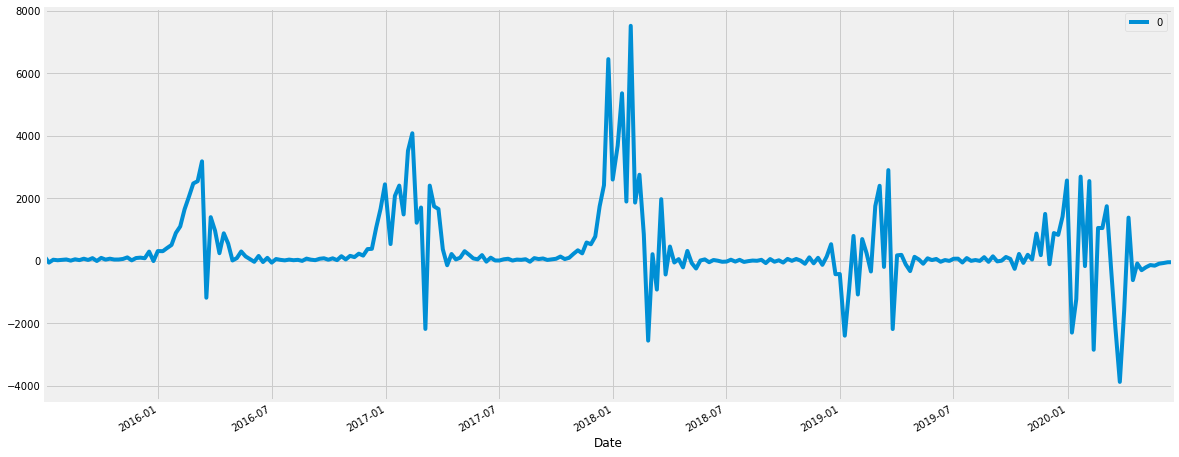

<Figure size 1440x288 with 0 Axes>

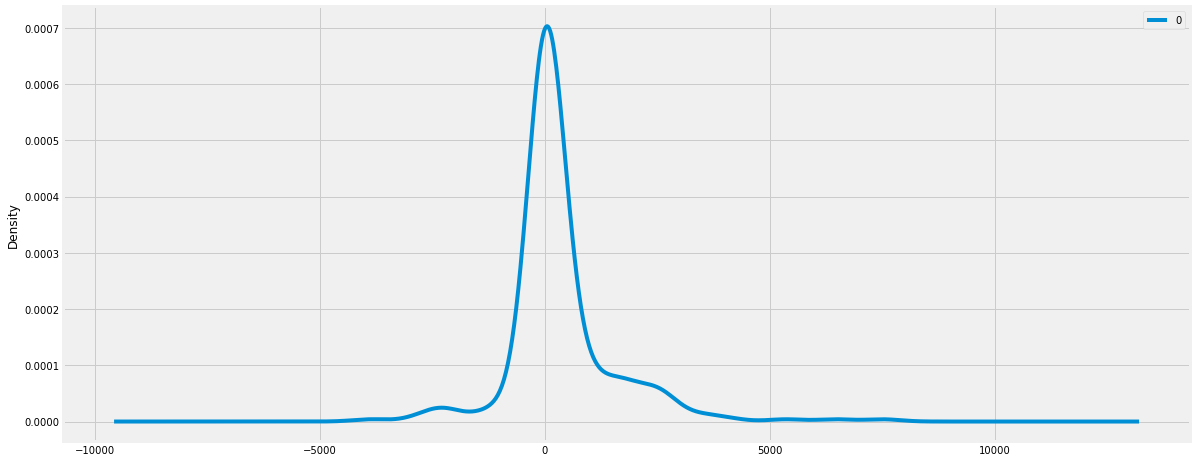

                 0
count   259.000000
mean    354.294687
std    1191.341516
min   -3883.397129
25%     -15.515997
50%      50.862225
75%     317.894329
max    7510.686379


In [26]:
mod = sm.tsa.statespace.SARIMAX(y3,
                                order=(3, 0, 0),
                                seasonal_order=(3, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.figure(figsize=(20, 4))
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [34]:
from statsmodels.tsa.arima_model import ARIMA
#model = ARIMA(dfx2, order=(1,1,0), freq='W-SUN') # MS stands for 'Month Start' in time series frequencies
#model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
#residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
#plt.show()
#residuals.plot(kind='kde')
#plt.show()
#print(residuals.describe())

In [27]:
residuals

,0
Date,
2015-07-02,129.000000
2015-07-09,-65.346237
2015-07-16,25.855312
2015-07-23,9.429694
2015-07-30,20.422212
...,...
2020-05-20,-164.495737
2020-05-27,-101.142745
2020-06-03,-80.236543


We should always run model diagnostics to investigate any unusual behavior.

In [28]:
print(results.plot_diagnostics)

<bound method MLEResults.plot_diagnostics of <statsmodels.tsa.statespace.sarimax.SARIMAXResults object at 0x0000025E24BADE10>>


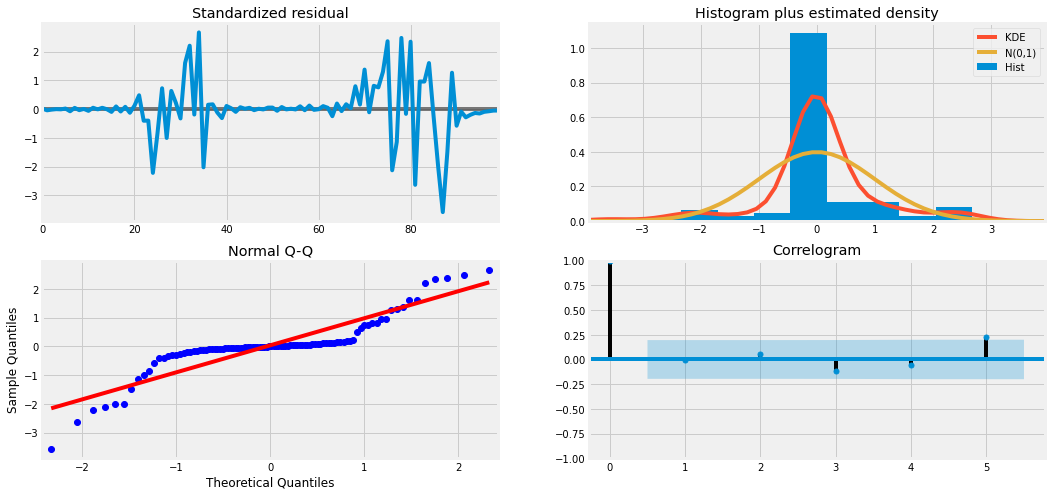

In [29]:
results.plot_diagnostics(lags=5, figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

# Producing and visualizing forecasts

### Validating forecasts (Q3)
To help us understand the accuracy of our forecasts, we compare predicted values to real values of the time series, and we set forecasts to start at **[WHERE]**

In [30]:
y_truth = y[150:]
y_truth

y_truth = pd.DataFrame(y_truth)
#y_truth = y_truth.reset_index()
#y_truth.index = pd.DatetimeIndex(y_truth.Date)
#.to_period('W')# just added this 

#y_truth = y_truth.rename(columns={0: 'truth'})
y_truth.head()

,COUNT POSITIVE
Date,
2018-05-21/2018-05-27,481
2018-05-28/2018-06-03,338
2018-06-04/2018-06-10,193
2018-06-11/2018-06-17,178
2018-06-18/2018-06-24,138


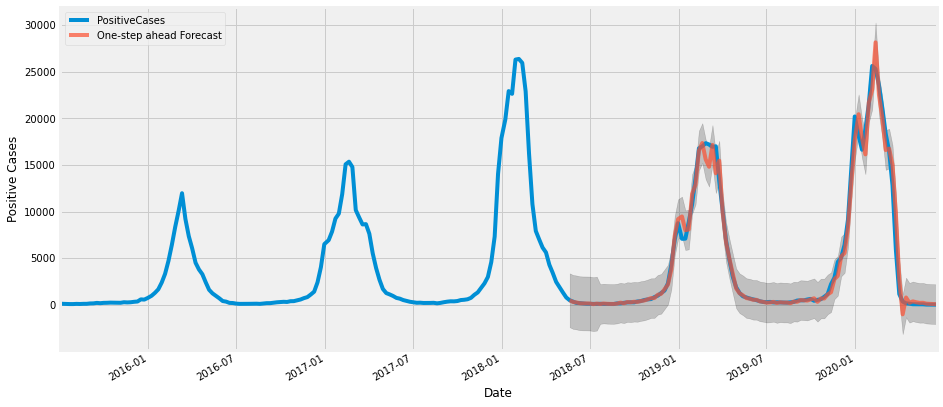

In [31]:
pred = results.get_prediction(start=150, dynamic=False)
pred_ci = pred.conf_int()
ax = dfx3.dropna().plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Positive Cases')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

This is get_predict

In [34]:
#need to get this working

y_forecasted = pred.predicted_mean

y_forecasted2 = pd.DataFrame(y_forecasted)
y_forecasted2 = y_forecasted2.reset_index()
y_forecasted2.head()
y_forecasted2.index = pd.DatetimeIndex(y_forecasted2.Date).to_period('W')# just added this 

y_forecasted2 = y_forecasted2.rename(columns={0: 'prediction'})
y_forecasted2


y_truth = y[150:]
mse = ((y_forecasted2['prediction']- y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 955197.75


In [35]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 977.34


## EXPLAIN CROSS VALIDATION HERE??

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html#Cross-validation


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average weekly positive cases in the test set within **SOME NUMBER ## of the real sales.** The weekly flu cases range from WHAT to WHAT. We believe this is **[GOOD / BAD MODEL SO FAR].** This will be closer to the units of measure. 

## Conclusion

## References
- Kevin's nephew
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- Class Slides
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.phe.gov/about/sns/Pages/default.aspx
- https://www.cdc.gov/flu/weekly/overview.htm
- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html#Cross-validation
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3  
- https://stackoverflow.com/questions/44235558/statespace-sarimax-model-why-the-model-use-all-the-data-to-train-mode-and-pred 
 
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 

- https://medium.com/datadriveninvestor/time-series-prediction-using-sarimax-a6604f258c56 

In [55]:
pred = results.get_forecast(steps=58,dynamic=False)
pred_ci2= pred.conf_int()
pred_ci2.head()

,lower PositiveCases,upper PositiveCases
208,-1080.538042,1602.242416
209,-1391.740084,1835.299637
210,-1485.825651,1973.213100
211,-1514.800749,1946.559645
212,-1524.001662,1958.849933


In [52]:
#this mess of code tries to line up preidcted and actuals and covert it back to time series as previous versions 
#were not plotting nicely
yplot = y3[20:]

pred_uc = results.get_forecast(steps =58)
pred_ci = pred_uc.conf_int()

preducmeandf = pd.DataFrame(pred_uc.predicted_mean)
preducmeandf2 = preducmeandf.reset_index(drop=True) 
pred_ci
yframe = pd.DataFrame(yplot)
yframe2 = yframe.reset_index()
resultsframe = yframe2.merge(preducmeandf2, left_index = True, right_index = True)
resultsframe= resultsframe.rename(columns={0: 'prediction'})
pred_cidf = pd.DataFrame(pred_ci)

pred_cidf = pred_cidf.reset_index(drop=True) 
pred_cidf
resultsframe = resultsframe.merge(pred_cidf, left_index = True, right_index = True)
resultsframe = resultsframe.set_index('Date')
resultsframe.index
resultsframe.head()

,PositiveCases,prediction,lower PositiveCases,upper PositiveCases
Date,,,,
2015-11-19,250,260.852187,-1080.538042,1602.242416
2015-11-26,268,221.779777,-1391.740084,1835.299637
2015-12-03,316,243.693724,-1485.825651,1973.213100
2015-12-10,348,215.879448,-1514.800749,1946.559645
2015-12-17,577,217.424135,-1524.001662,1958.849933


#im dont think we need this
# Sliding CV ... batches are mutually exclusive
pred = results.get_prediction(start=pd.to_datetime('2015-07-02'), dynamic=False)


batch_size = 20
start = 1
num_batches = len(dfx2)-batch_size+1
ASEs = []


for i in range(0, (num_batches-1)):
    results.get_prediction
    forecasts = pred 
    ASEs[i+1] = ((dfx2[start:(batch_size+1)] - pred )**2).mean()
    start = start+1



ASEs

print(ASEs.mean())
print(sd(ASEs))
